## Description:

    Hypothesis testing



# Setting variables

In [2]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/ordination/h_testing/'
biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'

biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [3]:
import os
from pandas import DataFrame
from IPython.display import FileLink

In [4]:
%matplotlib inline
%load_ext rpy2.ipython

In [5]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(vegan)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from

In [6]:
%%R
set.seed(605)

In [7]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Setting files

In [8]:
!cd $workDir; ln -f -s $biomFileDir$biomFile
!cd $workDir; ln -f -s $biomFileDir'../'$metadataFile
!cd $workDir; ls -thlc

total 32K
lrwxrwxrwx 1 bryan bryan 130 Nov 13 17:51 metadata_RhizCG_merged.txt -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/..//home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt
lrwxrwxrwx 1 bryan bryan 143 Nov 13 17:51 otu_table_wtax.biom -> /home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning//home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom
-rw-rw-r-- 1 bryan bryan 22K Oct 29 11:04 heatmap_rank2.pdf


# Loading/editting OTU table

In [9]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq = merge_phyloseq(physeq,sample.data)



In [10]:
%%R

sample_data(physeq)$Planted = ifelse(sample_data(physeq)$Plant == "BARE", "BARE", "Rhizosphere")
sample_data(physeq)$Planted


  [1] "BARE"        "BARE"        "BARE"        "BARE"        "BARE"       
  [6] "BARE"        "BARE"        "BARE"        "BARE"        "Rhizosphere"
 [11] "Rhizosphere" "BARE"        "Rhizosphere" "Rhizosphere" "Rhizosphere"
 [16] "BARE"        "Rhizosphere" "BARE"        "BARE"        "BARE"       
 [21] "BARE"        "Rhizosphere" "BARE"        "BARE"        "BARE"       
 [26] "Rhizosphere" "Rhizosphere" "BARE"        "Rhizosphere" "Rhizosphere"
 [31] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
 [36] "Rhizosphere" "BARE"        "BARE"        "Rhizosphere" "Rhizosphere"
 [41] "Rhizosphere" "Rhizosphere" "Rhizosphere" "BARE"        "BARE"       
 [46] "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere" "Rhizosphere"
 [51] "Rhizosphere" "BARE"        "Rhizosphere" "Rhizosphere" "Rhizosphere"
 [56] "BARE"        "BARE"        "Rhizosphere" "Rhizosphere" "Rhizosphere"
 [61] "Rhizosphere" "Rhizosphere" "BARE"        "Rhizosphere" "Rhizosphere"
 [66] "Rhizo

In [11]:
%%R
#subset out positive and negative controls
physeq = subset_samples(physeq, !is.na(DAP))

#remove two ECHCG plots where only soil and no roots were collected and sequenced
physeq = subset_samples(physeq, !(PlotID %in% c("4.16_Nneg", "4.16_Npos"))) 
print(physeq)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11246 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 11246 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 11246 tips and 11245 internal nodes ]


In [12]:
%%R
colnames(sample_data(physeq))

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"            


## Normalize samples and filter out taxa that are have less than three occurrances in more than 3 samples

In [13]:
%%R 
# filtering/normalizing
physeq.p = prune_samples(sampleSums(physeq) >= 10, physeq)


PassFilter = 
filter_taxa(physeq, 
             function(x) sum(x > 3) > 3, TRUE) %>%
                 taxa_names()

physeq.snorm = transform_sample_counts(physeq.p, function(x) x/sum(x))

physeq.snorm = prune_taxa(PassFilter, physeq)  
    
physeq.snorm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## Calculate pairwise weighted Unifrac distances between samples

In [14]:
%%R
registerDoParallel(cores=28)
wunif.dist = distance(physeq.snorm, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [27]:
%%R
physeq.snorm.Nneg = subset_samples(physeq.snorm, Treatment == "Nneg")
registerDoParallel(cores=28)
wunif.dist.Nneg = distance(physeq.snorm.Nneg, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [16]:
%%R
registerDoParallel(cores=28)
unif.dist = distance(physeq.snorm, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [17]:
%%R
registerDoParallel(cores=28)
unif.dist.Nneg = distance(physeq.snorm.Nneg, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

## NMDS of w-UniFrac and unweighted UniFrac

In [18]:
%%R -w 800 -h 350

sample_data(physeq.snorm)$DAP = factor(sample_data(physeq.snorm)$DAP)

sample_data(physeq.snorm)$Rep = factor(sample_data(physeq.snorm)$Rep)

nmds_w = ordinate(physeq.snorm, 
                method = "NMDS", 
                distance = wunif.dist)

nmds_u = ordinate(physeq.snorm, 
                method = "NMDS", 
                distance = unif.dist)


Run 0 stress 0.1405104 
Run 1 stress 0.1527848 
Run 2 stress 0.1420502 
Run 3 stress 0.1850273 
Run 4 stress 0.1555011 
Run 5 stress 0.155584 
Run 6 stress 0.16855 
Run 7 stress 0.1453772 
Run 8 stress 0.1922596 
Run 9 stress 0.1933912 
Run 10 stress 0.1765865 
Run 11 stress 0.1422168 
Run 12 stress 0.171754 
Run 13 stress 0.1430624 
Run 14 stress 0.1577343 
Run 15 stress 0.1430439 
Run 16 stress 0.1636811 
Run 17 stress 0.1434255 
Run 18 stress 0.1580137 
Run 19 stress 0.1801313 
Run 20 stress 0.1420489 
Run 0 stress 0.1519007 
Run 1 stress 0.1620203 
Run 2 stress 0.1753583 
Run 3 stress 0.1889246 
Run 4 stress 0.1790479 
Run 5 stress 0.1582166 
Run 6 stress 0.1657019 
Run 7 stress 0.1747156 
Run 8 stress 0.1635889 
Run 9 stress 0.1518809 
... New best solution
... procrustes: rmse 0.001220181  max resid 0.01019116 
Run 10 stress 0.1670052 
Run 11 stress 0.4174147 
Run 12 stress 0.1818095 
Run 13 stress 0.1862981 
Run 14 stress 0.1770946 
Run 15 stress 0.151903 
... procrustes: rmse 0

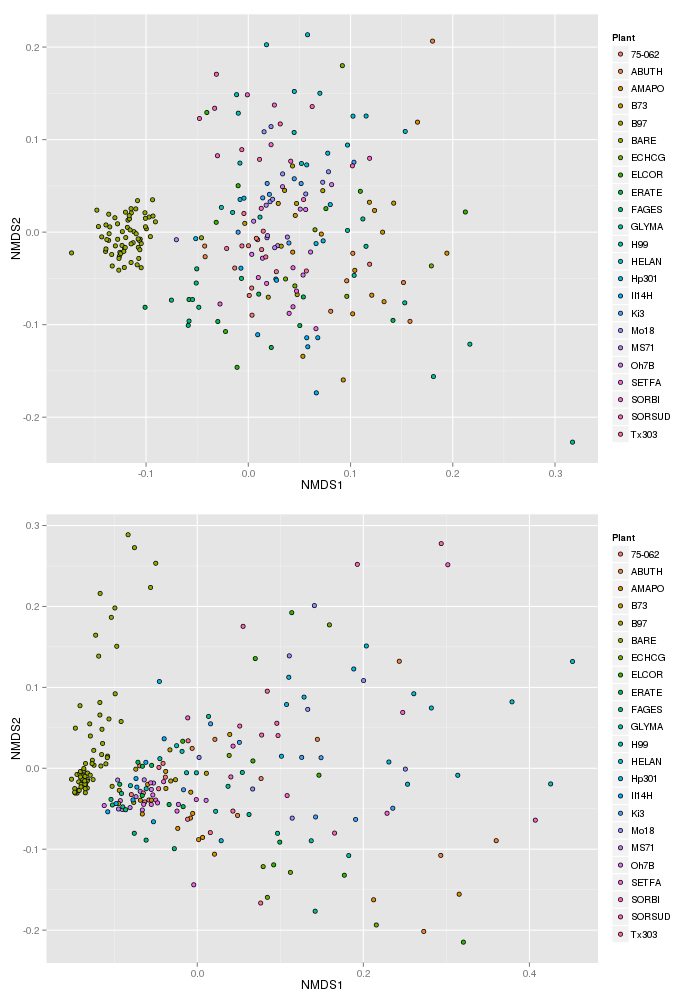

In [19]:
%%R -w 700 -h 1000
p = plot_ordination(physeq.snorm, nmds_w, justDF = TRUE)
p_u = plot_ordination(physeq.snorm, nmds_u, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch = 21)
        #scale_size(range=c(2,8))

p2 = ggplot(p_u, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), pch=21) 
        #scale_size(range=c(2,8))

grid.arrange(p1, p2, ncol=1)

Unweighted UniFrac results in much higher dispersion than weighted unifrac

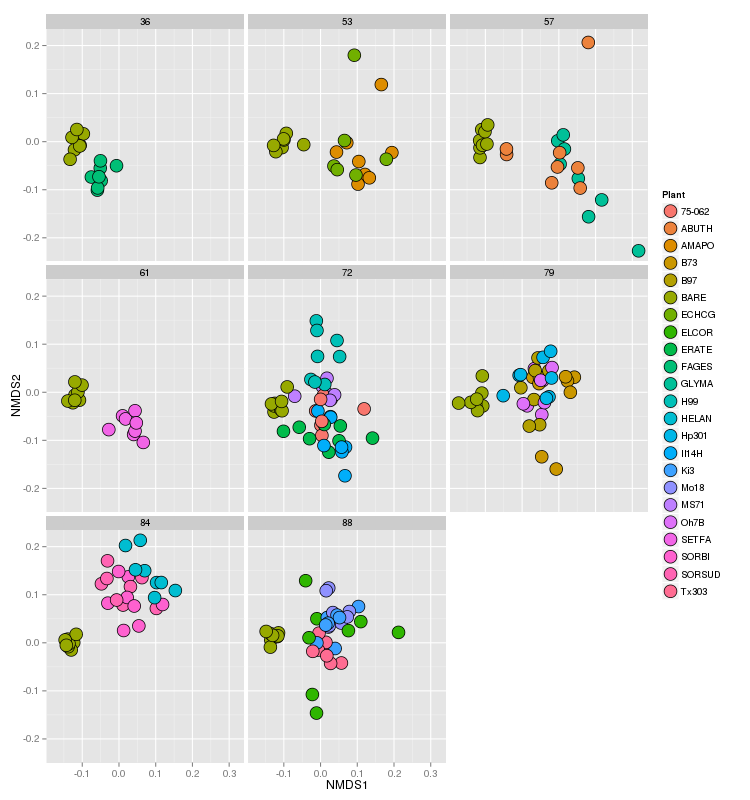

In [20]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch = 21) +
        facet_wrap(~ DAP) +
        scale_size(range=c(2,8))

p1

## Hypothesis testing of weighted and un-weighted unifrac

In [21]:
%%R
df = as(sample_data(physeq.snorm), "data.frame")
d = wunif.dist
Fulladonis = adonis(formula = d ~ DAP +  Planted + Plant + Treatment + Rep, df, strata = df$Rep:df$Plant, permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ DAP + Planted + Plant + Treatment + Rep,      data = df, permutations = 999, strata = df$Rep:df$Plant) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
DAP         7    1.1418 0.16311  15.494 0.17738  0.001 ***
Planted     1    1.7498 1.74978 166.215 0.27184  0.001 ***
Plant      21    1.2541 0.05972   5.673 0.19483  0.019 *  
Treatment   1    0.0420 0.04197   3.987 0.00652  0.001 ***
Rep         3    0.1017 0.03391   3.221 0.01580  0.001 ***
Residuals 204    2.1475 0.01053         0.33363           
Total     237    6.4368                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [28]:
%%R
#Check model without Treatment effect only Nneg
df = as(sample_data(physeq.snorm.Nneg), "data.frame")
d = wunif.dist.Nneg
Fulladonis = adonis(formula = d ~ DAP +  Planted + Plant + Rep + DAP:Planted, df, strata = df$Rep, permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ DAP + Planted + Plant + Rep + DAP:Planted,      data = df, permutations = 999, strata = df$Rep) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
DAP         7   0.62346 0.08907   9.348 0.20843  0.001 ***
Planted     1   0.81390 0.81390  85.421 0.27210  0.001 ***
Plant      21   0.67916 0.03234   3.394 0.22706  0.001 ***
Rep         3   0.05522 0.01841   1.932 0.01846  0.001 ***
Residuals  86   0.81942 0.00953         0.27395           
Total     118   2.99116                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [29]:
%%R
df = as(sample_data(physeq.snorm), "data.frame")
d = unif.dist
Fulladonis = adonis(formula = d ~ DAP +  Planted + Plant + Treatment + Rep, df, strata = df$Rep:df$Plant, permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ DAP + Planted + Plant + Treatment + Rep,      data = df, permutations = 999, strata = df$Rep:df$Plant) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
DAP         7    2.7473 0.39247   6.897 0.14127  0.001 ***
Planted     1    2.0349 2.03487  35.758 0.10464  0.002 ** 
Plant      21    2.5729 0.12252   2.153 0.13231  0.196    
Treatment   1    0.1265 0.12648   2.223 0.00650  0.001 ***
Rep         3    0.3560 0.11866   2.085 0.01831  0.001 ***
Residuals 204   11.6089 0.05691         0.59697           
Total     237   19.4464                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [31]:
%%R
df = as(sample_data(physeq.snorm.Nneg), "data.frame")
d = unif.dist.Nneg
Fulladonis = adonis(formula = d ~ DAP +  Planted + Plant + Rep, df, strata = df$Rep, permutations = 999)
Fulladonis


Call:
adonis(formula = d ~ DAP + Planted + Plant + Rep, data = df,      permutations = 999, strata = df$Rep) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
DAP         7    1.4962 0.21374  3.8630 0.16201  0.001 ***
Planted     1    0.9923 0.99230 17.9338 0.10744  0.001 ***
Plant      21    1.7360 0.08267  1.4941 0.18797  0.001 ***
Rep         3    0.2525 0.08415  1.5209 0.02734  0.001 ***
Residuals  86    4.7585 0.05533         0.51524           
Total     118    9.2354                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Bare soils change with time w-UniFrac

In [25]:
%%R

bare = subset_samples(physeq.snorm, Plant == "BARE")
sample_data(bare)$DAP = factor(sample_data(bare)$DAP)


In [32]:
%%R
registerDoParallel(cores=28)
bare.wunif.dist = distance(bare, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [34]:
%%R -w 800 -h 350


nmds = ordinate(bare, 
                method = "NMDS", 
               distance = bare.wunif.dist)

p = plot_ordination(bare, nmds, justDF = TRUE)

Run 0 stress 0.1542436 
Run 1 stress 0.1542445 
... procrustes: rmse 0.0003269234  max resid 0.001548909 
*** Solution reached


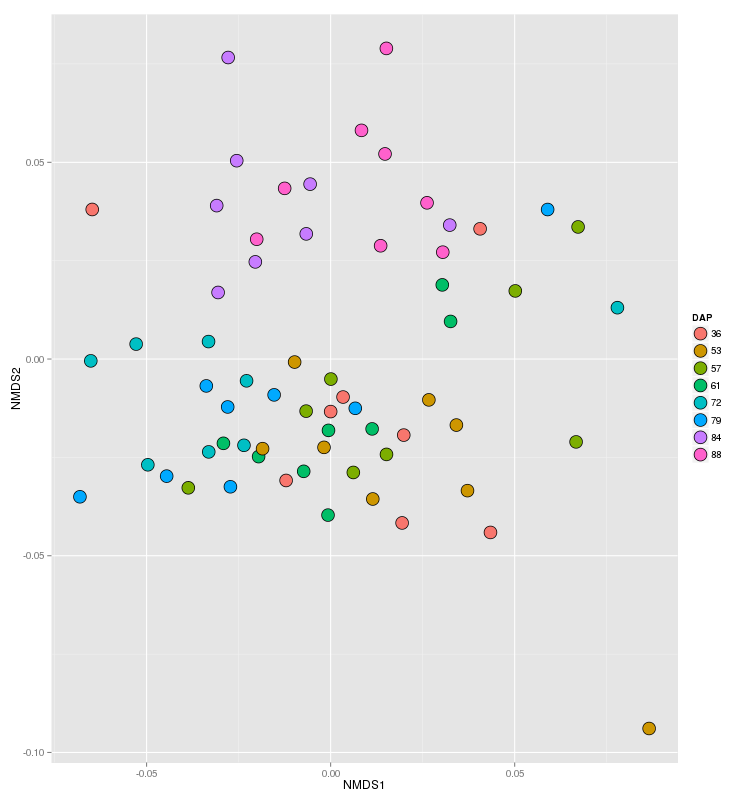

In [35]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=DAP), size = 6, pch=21) 

p1

### Hypothesis Test adonis

In [54]:
%%R
df = as(sample_data(bare), "data.frame")
d = bare.wunif.dist
bareadonis = adonis(d ~ DAP*Treatment + Rep, df, strata = df$Rep)
bareadonis


Call:
adonis(formula = d ~ DAP * Treatment + Rep, data = df, strata = df$Rep) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

              Df SumsOfSqs   MeanSqs F.Model      R2 Pr(>F)    
DAP            7   0.09273 0.0132465  3.4007 0.28379  0.001 ***
Treatment      1   0.00598 0.0059844  1.5363 0.01832  0.124    
Rep            3   0.03059 0.0101961  2.6176 0.09362  0.001 ***
DAP:Treatment  7   0.02215 0.0031645  0.8124 0.06780  0.846    
Residuals     45   0.17529 0.0038953         0.53648           
Total         63   0.32674                   1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Bare Soil Change with Time uw-UniFrac

In [40]:
%%R
registerDoParallel(cores=28)
bare.unif.dist = distance(bare, 
                      method = "unifrac", 
                      weighted = FALSE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [48]:
%%R -w 800 -h 350


nmds = ordinate(bare, 
                method = "NMDS", 
               distance = bare.unif.dist)

p = plot_ordination(bare, nmds, justDF = TRUE)

Run 0 stress 0.1111079 
Run 1 stress 0.1146882 
Run 2 stress 0.1161507 
Run 3 stress 0.1136405 
Run 4 stress 0.1140788 
Run 5 stress 0.1175778 
Run 6 stress 0.1151025 
Run 7 stress 0.1180198 
Run 8 stress 0.1142853 
Run 9 stress 0.1145322 
Run 10 stress 0.1127291 
Run 11 stress 0.1155822 
Run 12 stress 0.1175356 
Run 13 stress 0.1169393 
Run 14 stress 0.1155731 
Run 15 stress 0.1147609 
Run 16 stress 0.1180242 
Run 17 stress 0.111926 
Run 18 stress 0.1142456 
Run 19 stress 0.1120073 
Run 20 stress 0.1148842 


In [50]:
%%R -w 800 -h 350


nmds = ordinate(bare, 
                method = "NMDS", 
               distance = bare.unif.dist)

p = plot_ordination(bare, nmds, justDF = TRUE)

Run 0 stress 0.1111079 
Run 1 stress 0.117087 
Run 2 stress 0.11474 
Run 3 stress 0.1129489 
Run 4 stress 0.1144924 
Run 5 stress 0.1164734 
Run 6 stress 0.1167759 
Run 7 stress 0.1167862 
Run 8 stress 0.1156088 
Run 9 stress 0.1139262 
Run 10 stress 0.118458 
Run 11 stress 0.1114278 
... procrustes: rmse 0.05360145  max resid 0.22689 
Run 12 stress 0.1144422 
Run 13 stress 0.111394 
... procrustes: rmse 0.05597038  max resid 0.2240986 
Run 14 stress 0.1170691 
Run 15 stress 0.1172093 
Run 16 stress 0.115787 
Run 17 stress 0.116516 
Run 18 stress 0.1137862 
Run 19 stress 0.1111616 
... procrustes: rmse 0.04629873  max resid 0.2340944 
Run 20 stress 0.118338 


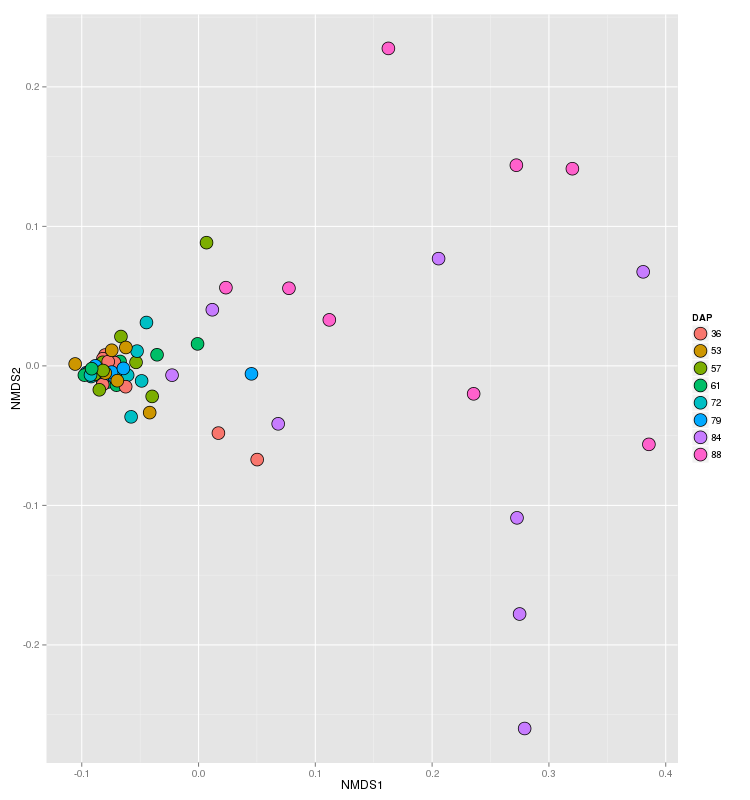

In [51]:
%%R -w 750 -h 800


## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=DAP), size = 6, pch=21) 

p1

### Hypothesis Test adonis

In [53]:
%%R
df = as(sample_data(bare), "data.frame")
d = bare.unif.dist
bareadonis = adonis(d ~ DAP*Treatment + Rep, df, strata = df$Rep)
bareadonis


Call:
adonis(formula = d ~ DAP * Treatment + Rep, data = df, strata = df$Rep) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

              Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
DAP            7   0.92294 0.131849  3.6794 0.30882  0.001 ***
Treatment      1   0.05671 0.056709  1.5825 0.01897  0.086 .  
Rep            3   0.15241 0.050805  1.4178 0.05100  0.001 ***
DAP:Treatment  7   0.24402 0.034860  0.9728 0.08165  0.521    
Residuals     45   1.61255 0.035834         0.53956           
Total         63   2.98864                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Rhizosphere Ordination

In [60]:
%%R

plant = subset_samples(physeq.snorm, Plant != "BARE")

#remove taxa that aren't in any plant samples
plant = filter_taxa(plant, function(x) max(x) > 0, TRUE)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4981 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 4981 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4981 tips and 4980 internal nodes ]


In [63]:
%%R
registerDoParallel(cores=28)
plant.wunif.dist = distance(plant, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [65]:
%%R
df = as(sample_data(plant), "data.frame")
d = plant.wunif.dist
plantadonis = adonis(d ~ DAP + Plant + Treatment, df, strata = df$Rep)
plantadonis


Call:
adonis(formula = d ~ DAP + Plant + Treatment, data = df, strata = df$Rep) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
DAP         7    1.3964 0.199487 15.0421 0.32774  0.001 ***
Plant      14    0.8071 0.057650  4.3471 0.18943  0.001 ***
Treatment   1    0.0547 0.054685  4.1235 0.01283  0.002 ** 
Residuals 151    2.0025 0.013262         0.47000           
Total     173    4.2608                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### subset just plants from Nneg and Npos

In [61]:
%%R

plantNneg = subset_samples(plant, Treatment == "Nneg")
sample_data(plantNneg)$DAP = factor(sample_data(plantNneg)$DAP)
plantNneg %>% print
plantNpos = subset_samples(plant, Treatment == "Npos")
sample_data(plantNpos)$DAP = factor(sample_data(plantNpos)$DAP)
plantNpos %>% print

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4981 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 4981 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4981 tips and 4980 internal nodes ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4981 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 4981 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4981 tips and 4980 internal nodes ]


Run 0 stress 0.1710848 
Run 1 stress 0.1746419 
Run 2 stress 0.1710837 
... New best solution
... procrustes: rmse 0.0002298753  max resid 0.002569713 
*** Solution reached


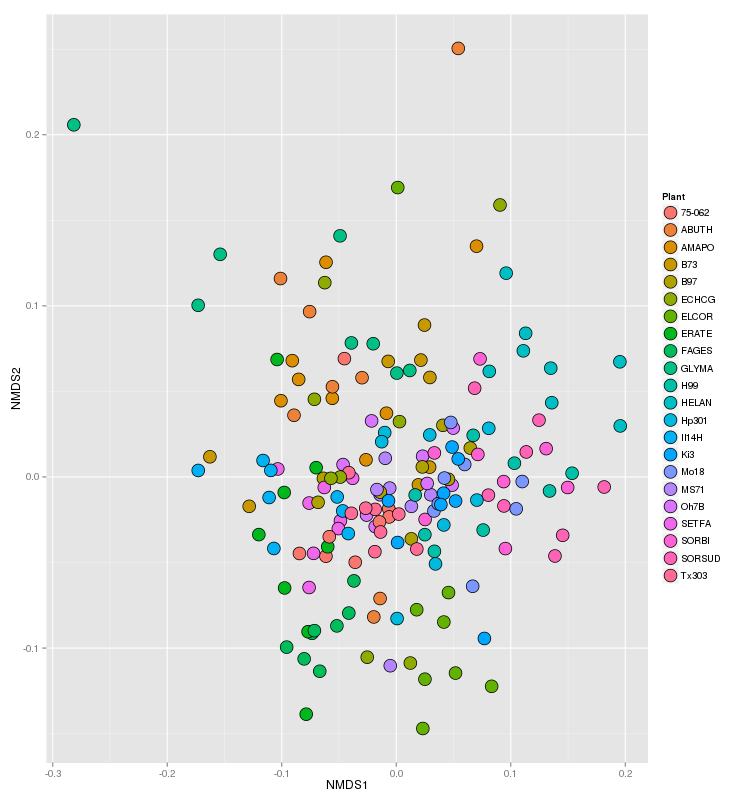

In [25]:
%%R -w 750 -h 800
#Whole plant set

plantnmds = ordinate(plant, 
                method = "NMDS", 
               distance = plant.wunif.dist)

p = plot_ordination(plant, plantnmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) 

p1

Run 0 stress 0.164082 
Run 1 stress 0.1894401 
Run 2 stress 0.2173661 
Run 3 stress 0.1949009 
Run 4 stress 0.1577954 
... New best solution
... procrustes: rmse 0.03591861  max resid 0.256015 
Run 5 stress 0.1683086 
Run 6 stress 0.1577953 
... New best solution
... procrustes: rmse 3.209961e-05  max resid 0.0002477847 
*** Solution reached


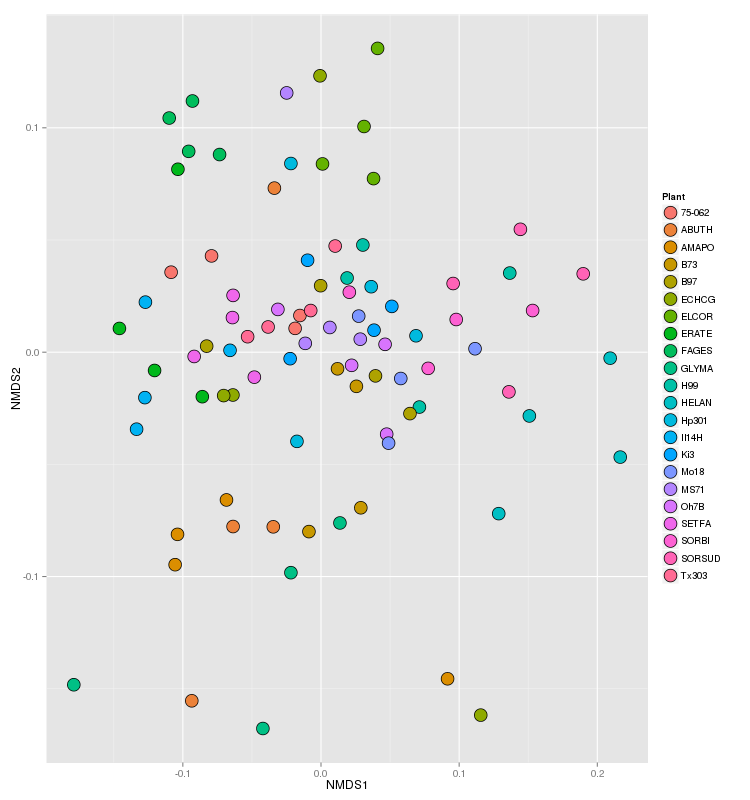

In [27]:
%%R -w 750 -h 800
#Whole plant set

plantNnegnmds = ordinate(plantNneg, 
                method = "NMDS", 
               distance = plantNneg.wunif.dist)

p = plot_ordination(plantNneg, plantNnegnmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) 

p1

Run 0 stress 0.1728807 
Run 1 stress 0.1728826 
... procrustes: rmse 0.0005883523  max resid 0.004968926 
*** Solution reached


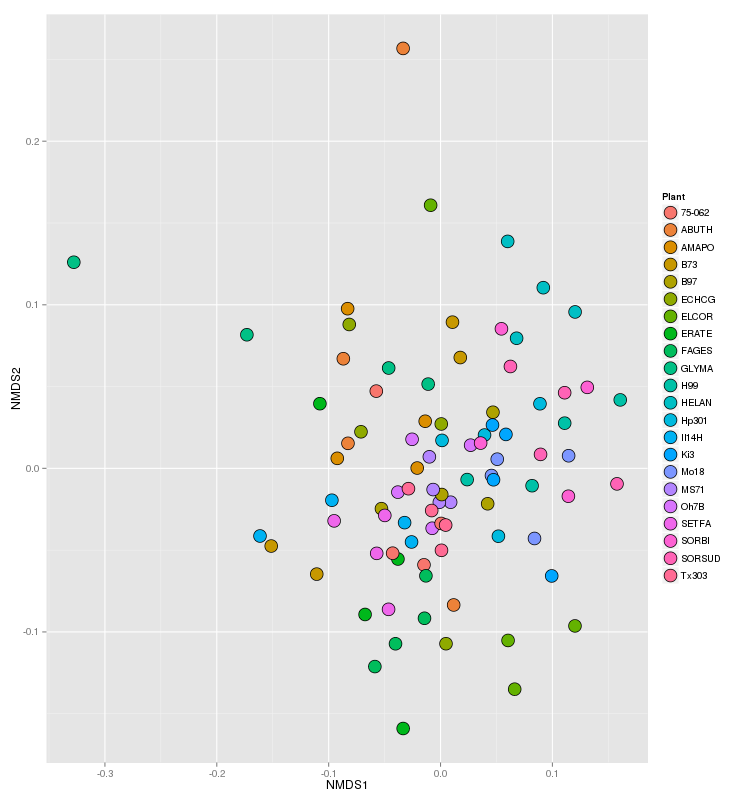

In [28]:
%%R -w 750 -h 800
#Whole plant set

plantNposnmds = ordinate(plantNpos, 
                method = "NMDS", 
               distance = plantNpos.wunif.dist)

p = plot_ordination(plantNpos, plantNposnmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) 

p1


## subset for particular day to test significance of plant while controlling for date

In [66]:
%%R
plant88 = subset_samples(plantNneg, DAP == 88)
plant88

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4981 taxa and 16 samples ]
sample_data() Sample Data:       [ 16 samples by 22 sample variables ]
tax_table()   Taxonomy Table:    [ 4981 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4981 tips and 4980 internal nodes ]


In [67]:
%%R
registerDoParallel(cores=28)
plant88.wunif.dist = distance(plant88, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

Run 0 stress 0.09862768 
Run 1 stress 0.1076345 
Run 2 stress 0.1076345 
Run 3 stress 0.09862762 
... New best solution
... procrustes: rmse 6.947001e-05  max resid 0.0002257924 
*** Solution reached


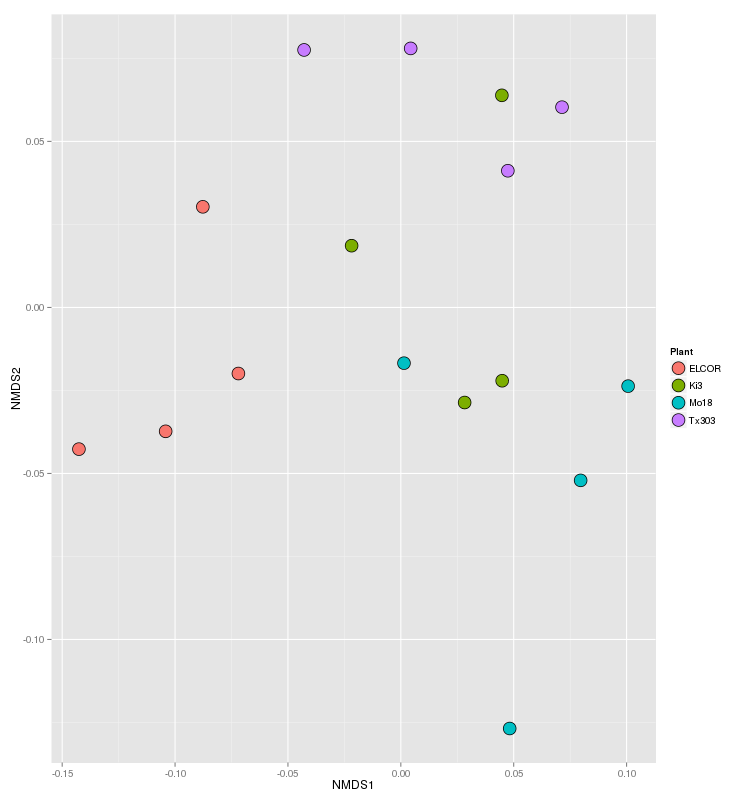

In [68]:
%%R -w 750 -h 800
#Day 88

plantnmds = ordinate(plant88, 
                method = "NMDS", 
               distance = plant88.wunif.dist)

p = plot_ordination(plant88, plantnmds, justDF = TRUE)

## generating plots
p1 = ggplot(p, aes(x = NMDS1, y = NMDS2)) +
        geom_point(aes(fill=Plant), size = 6, pch=21) 

p1

## Significance test of plant effect on single day

In [71]:
%%R
df = as(sample_data(plant88), "data.frame")
d = plant88.wunif.dist
plantadonis = adonis(d ~ Plant + Rep, df, strata = df$Rep)
plantadonis


Call:
adonis(formula = d ~ Plant + Rep, data = df, strata = df$Rep) 

Blocks:  strata 
Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)    
Plant      3  0.097094 0.032365  3.6991 0.45604  0.001 ***
Rep        3  0.037070 0.012357  1.4123 0.17411  0.001 ***
Residuals  9  0.078743 0.008749         0.36985           
Total     15  0.212907                  1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
